## Imports

#### General

In [1]:
import pandas as pd
import numpy as np

#### For clustering

In [2]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.cluster import SpectralClustering

#### For plotting

In [3]:
import matplotlib.pyplot as plt

## Read in the data

### Read in data 1

In [4]:
df1 = pd.read_csv("./data_1.csv")

#### Inspect the data

In [5]:
df1.head()

,group,SubID,LR,Outcome_Sens,Response_cons,Loss_Aver
0,young,1,0.159011,0.487522,0.686815,0.954498
1,young,2,0.064666,0.511008,1.391790,0.295529
2,young,3,0.113089,0.465141,0.918734,0.533232
3,young,4,0.089273,0.500391,0.703737,0.869859
4,young,5,0.233898,0.488053,0.897867,0.511095


In [6]:
df1.describe()

,SubID,LR,Outcome_Sens,Response_cons,Loss_Aver
count,153.000000,153.000000,153.000000,153.000000,153.000000
mean,77.000000,0.254555,0.490149,1.047426,0.771240
std,44.311398,0.237008,0.155386,0.400147,0.651220
min,1.000000,0.024038,0.049304,0.590758,0.043900
25%,39.000000,0.089273,0.401523,0.730751,0.282991
50%,77.000000,0.158341,0.490751,0.918049,0.660665
75%,115.000000,0.294708,0.560787,1.284732,1.054360
max,153.000000,0.942930,0.925102,2.449047,4.084854


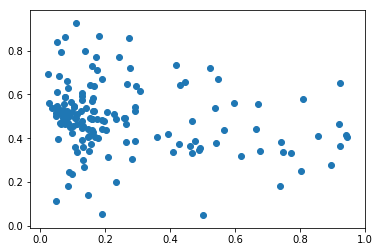

In [7]:
plt.scatter(df1["LR"], df1["Outcome_Sens"])

### Read in data 2

In [8]:
df2 = pd.read_csv("./data_2.csv")

#### Inspect the data

In [9]:
df2.head()

,group,SubID,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
0,young,1,0.038441,0.630402,1.207295,1.050323,-0.535035,-1.913099,0.669323,0.660446
1,young,2,0.045673,0.630331,1.628191,0.205205,-0.133367,-1.423580,0.427207,0.719352
2,young,3,0.045468,0.602974,1.395572,0.383055,-0.344822,-1.719826,0.493249,0.688723
3,young,4,0.035789,0.635677,1.067831,0.823790,-0.229192,-1.484455,0.625835,0.675971
4,young,5,0.060655,0.636276,1.802964,0.329246,-0.616020,-2.561017,0.439912,0.655563


### Read in data 3

In [10]:
df3 = pd.read_csv("./data_3.csv")

#### Inspect the data

In [11]:
df3.head()

,subjID,A+,A-,K,BetaF,BetaP,A+-A-
0,old,0.324444,0.068862,1.502130,2.523191,-5.547480,0.255581
1,old,0.885744,0.120145,0.012591,3.193244,-9.159800,0.765598
2,old,0.318205,0.078128,1.927309,0.615708,9.272336,0.240077
3,old,0.728192,0.106737,0.388407,2.595746,-2.239555,0.621455
4,old,0.356229,0.091987,1.810674,0.508605,9.825699,0.264241


In [12]:
df3.describe()

,A+,A-,K,BetaF,BetaP,A+-A-
count,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000
mean,0.269832,0.081703,0.827168,1.635854,0.008024,0.188130
std,0.179846,0.050822,0.547490,1.100305,5.473899,0.171373
min,0.042396,0.020484,0.012591,-1.883399,-16.509583,-0.189094
25%,0.131825,0.044090,0.394005,0.967837,-3.315013,0.065641
50%,0.229936,0.066459,0.737739,1.714574,-1.159481,0.150801
75%,0.331607,0.113113,1.161452,2.304304,2.649135,0.263862
max,0.885744,0.318413,2.155364,4.502968,12.437878,0.765598


## Determine the best number of clusters

#### Set up the data for clustering

In [13]:
train_x = df1.iloc[:, 2:]

In [14]:
train_x.head()

,LR,Outcome_Sens,Response_cons,Loss_Aver
0,0.159011,0.487522,0.686815,0.954498
1,0.064666,0.511008,1.391790,0.295529
2,0.113089,0.465141,0.918734,0.533232
3,0.089273,0.500391,0.703737,0.869859
4,0.233898,0.488053,0.897867,0.511095


In [15]:
train_x.describe()

,LR,Outcome_Sens,Response_cons,Loss_Aver
count,153.000000,153.000000,153.000000,153.000000
mean,0.254555,0.490149,1.047426,0.771240
std,0.237008,0.155386,0.400147,0.651220
min,0.024038,0.049304,0.590758,0.043900
25%,0.089273,0.401523,0.730751,0.282991
50%,0.158341,0.490751,0.918049,0.660665
75%,0.294708,0.560787,1.284732,1.054360
max,0.942930,0.925102,2.449047,4.084854


## Create an elbow curve to determine the best number of clusters

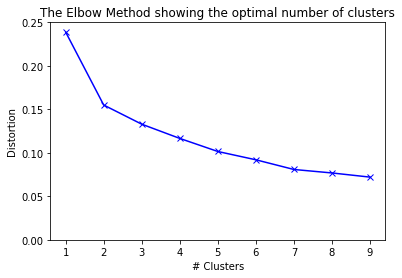

In [16]:
col_1 = train_x.iloc[:, 0]
col_2 = train_x.iloc[:, 1]

# create new plot and data
X = np.array(list(zip(col_1, col_2))).reshape(len(col_1), 2)

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('# Clusters')
plt.ylabel('Distortion')
plt.ylim([0, 0.25])
plt.title('The Elbow Method showing the optimal number of clusters')
plt.show()

### Use the above graph to set the number of clusters

In [17]:
num_clusters = 7

## Find out which of the 7 clusters each df row is in

#### Cluster the data

In [18]:
clustering = SpectralClustering(n_clusters=num_clusters, assign_labels="discretize", random_state=0).fit(train_x)
clusters_label = pd.DataFrame(clustering.labels_).rename(columns={0: "Cluster"})

#### Add a new column to the original data with the cluster each row is in

In [19]:
full_df = pd.concat([df1, clusters_label], axis=1)

In [20]:
full_df.head()

,group,SubID,LR,Outcome_Sens,Response_cons,Loss_Aver,Cluster
0,young,1,0.159011,0.487522,0.686815,0.954498,2
1,young,2,0.064666,0.511008,1.391790,0.295529,4
2,young,3,0.113089,0.465141,0.918734,0.533232,2
3,young,4,0.089273,0.500391,0.703737,0.869859,2
4,young,5,0.233898,0.488053,0.897867,0.511095,2


## Plot the clusters

#### Choose the columns to plot

In [21]:
x = full_df.iloc[:, 2]
y = full_df.iloc[:, 3]

#### Plot the original data

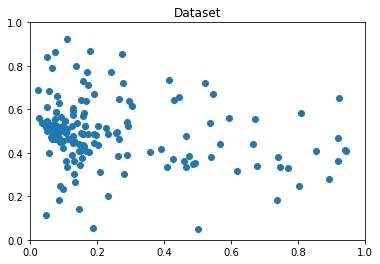

In [22]:
plt.plot()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('Dataset')
plt.scatter(x, y)
plt.show()

#### Plot this data with the clusters

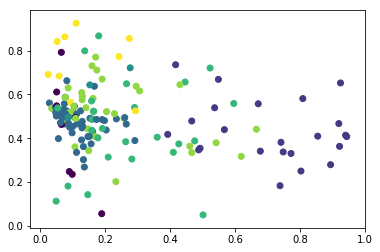

In [23]:
plt.scatter(x, y, c=full_df["Cluster"])

#### Plot this data with the clusters and their centroids

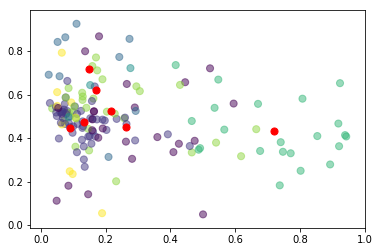

In [24]:
kmeans = KMeans(n_clusters=num_clusters).fit(train_x)
centroids = kmeans.cluster_centers_

plt.scatter(x, y, c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

## See how the 'Old' and 'Young' fall into these clusters

In [25]:
full_df.head()

,group,SubID,LR,Outcome_Sens,Response_cons,Loss_Aver,Cluster
0,young,1,0.159011,0.487522,0.686815,0.954498,2
1,young,2,0.064666,0.511008,1.391790,0.295529,4
2,young,3,0.113089,0.465141,0.918734,0.533232,2
3,young,4,0.089273,0.500391,0.703737,0.869859,2
4,young,5,0.233898,0.488053,0.897867,0.511095,2


#### Create a dataframe showing how many people people fell into each cluster

In [26]:
all_cluster_df = pd.DataFrame(full_df[["group", "Cluster"]].groupby("Cluster").count()).rename(columns={"group": "All"})

#### Change 'young' to 1 and 'old' to np.nan

In [27]:
full_df["group"] = full_df["group"].replace('old', np.nan).replace('young', 1)
full_df.head()

,group,SubID,LR,Outcome_Sens,Response_cons,Loss_Aver,Cluster
0,1.0,1,0.159011,0.487522,0.686815,0.954498,2
1,1.0,2,0.064666,0.511008,1.391790,0.295529,4
2,1.0,3,0.113089,0.465141,0.918734,0.533232,2
3,1.0,4,0.089273,0.500391,0.703737,0.869859,2
4,1.0,5,0.233898,0.488053,0.897867,0.511095,2


#### Create a dataframe showing how many young people fell into each cluster

In [28]:
young_cluster_df = pd.DataFrame(full_df[["group", "Cluster"]].groupby("Cluster").count()).rename(columns={"group": "Young"})

#### Create a dataframe showing how many old people fell into each cluster

In [29]:
old_cluster_df = pd.DataFrame(full_df["group"].isnull().groupby(full_df["Cluster"]).sum().astype(int)).rename(columns={"group": "Old"})

#### Output how many 'young' and 'old' people fell into each cluster

In [30]:
pd.merge(all_cluster_df, pd.merge(young_cluster_df, old_cluster_df, how="inner", on="Cluster"), how="inner", on="Cluster")

,All,Young,Old
Cluster,,,
0,8,5,3
1,23,2,21
2,50,37,13
3,3,3,0
4,27,9,18
5,33,29,4
6,9,5,4
